# Финальный проект

-------------------------------------------------------

# Import libs

In [34]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
sys.path.append(os.path.abspath('../src/'))

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items, PrefilterItems
from recommenders import ALSRecommendation, OwnRecommendation, PopularItemsRecommendation, BaseRecommender, ClassificationModel, LightGBMRecommendation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import requests

tg_api_token = '5043397400:AAExpKcTarTWA2nYlvB_rOyL7vMVe8e1DFw'
tg_chat_id = '1971178318'

def send_tg_message(text='Cell execution completed.'):
    requests.post(
        'https://api.telegram.org/' +
        'bot{}/sendMessage'.format(tg_api_token), 
        params=dict(chat_id=tg_chat_id, text=text)
    )

## Read data

In [9]:
from pathlib import Path

DATA_PATH = Path('../Data/')
RETAIL_TRAIN_PATH = DATA_PATH / 'retail_train.csv'
ITEM_FEATURE_PATH = DATA_PATH / 'product.csv'
USER_FEATURE_PATH = DATA_PATH / 'hh_demographic.csv'
TEST_DATA = DATA_PATH / 'retail_test1.csv'

data = pd.read_csv(RETAIL_TRAIN_PATH)
item_features = pd.read_csv(ITEM_FEATURE_PATH)
user_features = pd.read_csv(USER_FEATURE_PATH)
test_data = pd.read_csv(TEST_DATA)


In [10]:
train_data = data.copy()

# Process features dataset

In [11]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

**TODO:** подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)

In [246]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель --


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [247]:
# данные со старых покупок до 9 недельной давности. Тренировка для модели первого уровня
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# данные от 9 недельной давности до 3 недельной давности. Тест для модели первого уровня
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели (не более 3 недельной давности)
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [248]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [249]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')
print_stats_data(test_data, 'test_data')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329
test_data
Shape: (88734, 12) Users: 1885 Items: 20497


# Prefilter items

In [17]:
#wrapper for prefilter func

class PrefilterItems:
    def __init__(self, items_data, take_n_popular, warm_start, main_data=None) -> None:
        self.main_data = main_data
        self.items_data = items_data
        self.take_n_popular =take_n_popular
        self.warm_start = warm_start
    
    def __call__(self, *args: 'Any', **kwds: 'Any') -> pd.DataFrame:
        params = {
            'data': self.main_data,
            'items_data': self.items_data,
            'take_n_popular': self.take_n_popular,
            'warm_start': self.warm_start
        }
        
        return prefilter_items(**params)
    

In [187]:
#TODO: подобрать take_n_popular

n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher,
                                     items_data=item_features, 
                                     take_n_popular=5000,
                                     warm_start=True
                                    )

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5000


# Make cold-start to warm-start

In [188]:
# TODO: make cold-start

# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

# warm-start: оставляем только тех пользователей которые есть во всех трех наборах данных
data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (1013530, 13) Users: 1904 Items: 5000
val_matcher
Shape: (162611, 12) Users: 1904 Items: 26640
train_ranker
Shape: (162611, 12) Users: 1904 Items: 26640
val_ranker
Shape: (115539, 12) Users: 1904 Items: 23734


**#TODO**: попробовать другие модели LinearRegression, LightFM

# Get candidates

In [189]:
ACTUAL_COL = 'actual'

def get_validation_data_frame(data_val):
    result_eval_matcher = data_val.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
    return result_eval_matcher


result_eval_matcher = get_validation_data_frame(data_val_matcher)
result_eval_matcher.head(2)


,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [190]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [191]:
# als_params = {'data':data_train_matcher, 'item_features': item_features, 'warm_start':True}

# als_model = ALSRecommendation(**als_params)
# als_model.fit()

# bpr_model = ALSRecommendation(**als_params, use_bpr=True)
# bpr_model.fit()

# own = OwnRecommendation(data_train_matcher, warm_start=True)
# own.fit()

# result: best model it's als_model

In [192]:
#uncoment if need

# from swifter import swifter
# N_PREDICT = 50

# models = {als_model:'als', bpr_model:'bpr'}
# recommend_methods = ['base', 'similar_items', 'similar_user_items']

# result_eval_matcher = get_validation_data_frame(data_val_matcher)

# for model, name in models.items():
#     for recommend_method in recommend_methods:
#         result_eval_matcher[name + '_' + recommend_method] = result_eval_matcher[USER_COL].swifter.apply(lambda x: model.recommend(user=x, N=N_PREDICT, how=recommend_method))

# result_eval_matcher['own'] = result_eval_matcher[USER_COL].swifter.apply(lambda x: own.recommend(user=x, N=N_PREDICT))
# result_eval_matcher.head(2)

In [193]:
# sorted(calc_recall(result_eval_matcher, N_PREDICT), key=lambda x: x[1],reverse=True)

Видно, что лучшая модель из предложеных - als

## Improve first level model

In [194]:
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

space = {
    'n_factors': hp.choice('n_factors', [200, 300, 400]),
    'regularization': hp.uniform('regularization', 0, 0.1),
    'iterations': hp.choice('iterations', [60, 70, 80]),
}

In [195]:
N_PREDICTS = 500

def hyperparametr_tuning(params):
    model = ALSRecommendation(**params,
                              data=data_train_matcher,
                              item_features=item_features,
                              warm_start=True,
                              how='bpr'
                             )

    model.fit()

    result_eval_matcher = get_validation_data_frame(data_val=data_val_matcher)
    result_eval_matcher['als'] = result_eval_matcher.user_id.apply(lambda x: model.recommend(x, N=N_PREDICTS))

    test_precision = list(calc_recall(result_eval_matcher, top_k=500))[0][1]

    return {'loss': -test_precision, 'status': STATUS_OK}

In [196]:
trial = Trials()

# best = fmin(
#     fn=hyperparametr_tuning,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=10,
#     trials=trial
# )

# print(f'Best {best}')
# send_tg_message('I calc hyperparametr for 1 level model. Best params is {}'.format(best))

# result is't 
# als_params = {'data':data_train_matcher, 'item_features': item_features, 'iterations':70, 'n_factors':400, 'regularization':0.018,'warm_start':True}

In [264]:
als_params = {'data':data_train_matcher, 'item_features': item_features, 'iterations':70, 'n_factors':400, 'regularization':0.018,'warm_start':True}
selected_model = ALSRecommendation(**als_params)
selected_model.fit()

## Подбор N_predict

In [21]:
N_PREDICT = 500

n_predicts = [20, 50, 100, 200, 500]
result_eval_matcher = get_validation_data_frame(data_val_matcher)

result_eval_matcher['als'] = result_eval_matcher[USER_COL].swifter.apply(lambda x: selected_model.recommend(user=x, N=N_PREDICT, how='base'))

recall_at_list = [round(list(calc_recall(result_eval_matcher, n_predict))[0][1], 5) for n_predict in n_predicts]

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

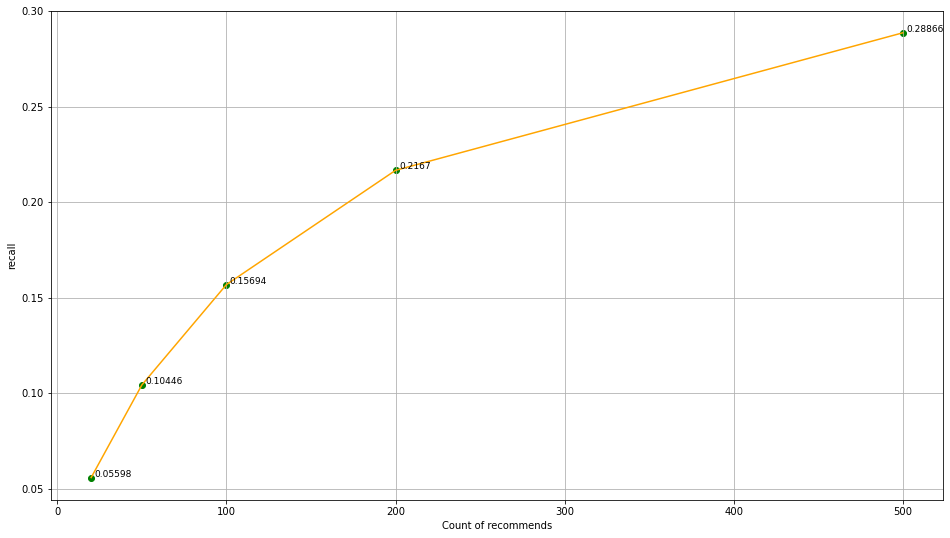

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(n_predicts, recall_at_list, c='orange')
plt.scatter(n_predicts, recall_at_list, c='green')

[plt.text(n_predicts[i] + 2, recall_at_list[i] + .0005, txt, fontsize=9) for i, txt in enumerate(recall_at_list)]

plt.grid()

plt.xlabel('Count of recommends')
plt.ylabel('recall')
plt.show()

# Подготовка данных для трейна

In [199]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]
df_match_candidates.head(2)

,user_id
0,2070
1,2021


In [200]:
# собираем кандитатов с первого этапа (matcher)
N_PREDICT=500

df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: selected_model.recommend(x, N=N_PREDICT))
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[8065410, 897954, 981760, 1000753, 1082185, 85..."
1,2021,"[950935, 1119454, 844179, 1019142, 1000753, 10..."


In [291]:
from recommenders import LightGBMRecommendation

df_ranker_train = LightGBMRecommendation.create_user_item_matrix(df_match_candidates, data_train_ranker)
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,8065410,0.0
1,2070,897954,0.0


## Add new features

In [202]:
# TODO: add other features
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,8065410,0.0
1,2070,897954,0.0


**Фичи user_id:**
   - Средний чек
   - Средняя сумма покупки 1 товара в каждой категории
   - Кол-во покупок в каждой категории
   - Частотность покупок раз/месяц
   - Долю покупок в выходные
   - Долю покупок утром/днем/вечером

**Фичи item_id**:
   - Кол-во покупок в неделю (как часто покупают этот товар)
   - Среднее ол-во покупок 1 товара в категории в неделю (насколько востребована категория)
   - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю) - процент востребованости этого товара в данной категории
   - Цена (Можно посчитать из retil_train.csv)
   - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
   - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
   - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
   - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [287]:
df_ranker_train = LightGBMRecommendation.additional_features(to=df_ranker_train, 
                                                              item_features=item_features,
                                                              user_features=user_features,
                                                              data_train=data_train_ranker)

df_ranker_train.head(2)

,user_id,item_id,target,avg_quantity_week,popular_department,higher_then_median_price_percent,popular_items_a_week,like_percent_a_department,avg_price_a_department,manufacturer,...,DELI/SNACK BAR_count,GM MERCH EXP_count,SEAFOOD_count,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,8065410,0.0,17.833333,1409.166667,87.683031,17.833333,1.265523,3.104766,397.0,...,0.0,0.0,0.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,897954,0.0,12.333333,1222.666667,64.451952,12.333333,1.008724,5.267633,4303.0,...,0.0,0.0,0.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


## Fill nan

In [204]:
nun_column_name = df_ranker_train.isna().sum()[df_ranker_train.isna().sum() > 0].index.to_list()

Float columns we going to fill with method knn from sklearn

In [205]:
float_columns = df_ranker_train[nun_column_name].dtypes[df_ranker_train[nun_column_name].dtypes == 'float64'].index.to_list()
float_columns

['avg_quantity_week',
 'popular_department',
 'higher_then_median_price_percent',
 'popular_items_a_week',
 'like_percent_a_department',
 'avg_price_a_department',
 'manufacturer']

Cat columns we going to fill most frequently values 

In [206]:
cat_columns = df_ranker_train[nun_column_name].dtypes[df_ranker_train[nun_column_name].dtypes == 'object'].index.to_list()

In [207]:
from sklearn.impute import SimpleImputer

df_ranker_train_copy = df_ranker_train.copy()


for num_column in float_columns:
    mean = round(df_ranker_train_copy[num_column].median(), 3)
    df_ranker_train_copy[num_column] = df_ranker_train_copy[num_column].fillna(mean)

cat_imputer = SimpleImputer(strategy='most_frequent', add_indicator=True)

def fill_nan(df_ranker_train_copy, imputer, nan_columns):

    columns = df_ranker_train_copy.columns.to_list()
    columns.extend(['is_' + column + '_miss' for column in nan_columns])
    

    df_ranker_train_copy = pd.DataFrame(
        data=imputer.fit_transform(df_ranker_train_copy),
        columns=columns
    )
    return df_ranker_train_copy

df_ranker_train_copy = fill_nan(df_ranker_train_copy, cat_imputer, cat_columns)

df_ranker_train_copy.head(2)

,user_id,item_id,target,avg_quantity_week,popular_department,higher_then_median_price_percent,popular_items_a_week,like_percent_a_department,avg_price_a_department,manufacturer,...,is_commodity_desc_miss,is_sub_commodity_desc_miss,is_curr_size_of_product_miss,is_age_desc_miss,is_marital_status_code_miss,is_income_desc_miss,is_homeowner_desc_miss,is_hh_comp_desc_miss,is_household_size_desc_miss,is_kid_category_desc_miss
0,2070,8065410,0.0,16.833333,1346.5,88.173612,16.833333,1.250155,3.103253,397.0,...,False,False,False,False,False,False,False,False,False,False
1,2070,897954,0.0,12.333333,1163.666667,64.450411,12.333333,1.059868,5.267759,4303.0,...,False,False,False,False,False,False,False,False,False,False


In [208]:
# преобразование в типов в изначальные
num_columns = df_ranker_train.dtypes[~(df_ranker_train.dtypes == 'object')].index.to_list()
for num_col in num_columns:
    df_ranker_train_copy[num_col] = pd.to_numeric(df_ranker_train_copy[num_col])

df_ranker_train_copy.dtypes

user_id                          int64
item_id                          int64
target                         float64
avg_quantity_week              float64
popular_department             float64
                                ...   
is_income_desc_miss             object
is_homeowner_desc_miss          object
is_hh_comp_desc_miss            object
is_household_size_desc_miss     object
is_kid_category_desc_miss       object
Length: 97, dtype: object

In [209]:
df_ranker_train = df_ranker_train_copy.copy()
df_ranker_train.isna().sum().sum()

0

## Create train data set

In [210]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [211]:
# from utils import reduce_mem_usage

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

reduce_mem_usage(X_train).head(2)

Memory usage of dataframe is 1623.71 MB
Memory usage after optimization is: 288.78 MB
Decreased by 82.2%


,user_id,item_id,avg_quantity_week,popular_department,higher_then_median_price_percent,popular_items_a_week,like_percent_a_department,avg_price_a_department,manufacturer,department,...,is_commodity_desc_miss,is_sub_commodity_desc_miss,is_curr_size_of_product_miss,is_age_desc_miss,is_marital_status_code_miss,is_income_desc_miss,is_homeowner_desc_miss,is_hh_comp_desc_miss,is_household_size_desc_miss,is_kid_category_desc_miss
0,2070,8065410,16.833334,1346.500000,88.173615,16.833334,1.250155,3.103253,397.0,MEAT-PCKGD,...,False,False,False,False,False,False,False,False,False,False
1,2070,897954,12.333333,1163.666626,64.450409,12.333333,1.059868,5.267759,4303.0,MEAT,...,False,False,False,False,False,False,False,False,False,False



# Select second level model

In [212]:
cat_features = X_train.dtypes[X_train.dtypes == 'category'].index.tolist()
cat_features

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'is_department_miss',
 'is_brand_miss',
 'is_commodity_desc_miss',
 'is_sub_commodity_desc_miss',
 'is_curr_size_of_product_miss',
 'is_age_desc_miss',
 'is_marital_status_code_miss',
 'is_income_desc_miss',
 'is_homeowner_desc_miss',
 'is_hh_comp_desc_miss',
 'is_household_size_desc_miss',
 'is_kid_category_desc_miss']

In [213]:
from abc import ABC, abstractmethod

class BaseRecommender(ABC):

    @abstractmethod
    def recommend(self, user, N=5, **kwargs):
        pass

In [284]:
import feature_generation
from sklearn.pipeline import make_pipeline

class ClassificationModel:
    def __init__(self):
        self.model = None

    @staticmethod
    def create_user_item_matrix(user_prediction: pd.DataFrame, train_data: pd.DataFrame):
        df_items = user_prediction.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1,
                                                                                                            drop=True)
        df_items.name = 'item_id'
        user_prediction = user_prediction.drop('candidates', axis=1).join(df_items)

        df_ranker_train = train_data[[USER_COL, ITEM_COL]].copy()
        df_ranker_train['target'] = 1  # тут только покупки

        df_ranker_train = user_prediction.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

        df_ranker_train['target'].fillna(0, inplace=True)
        return df_ranker_train

    @staticmethod
    def additional_features(to, item_features, user_features, data_train):
        additional_user_features = make_pipeline(
            feature_generation.AddPriceColumn(),
            feature_generation.AverageCheck(),
            feature_generation.AveragePriceCounItemADepartment(items_department=item_features[[ITEM_COL, DEPARTMENT_COL]]),
            feature_generation.PurchasesAMonth(),
            feature_generation.DropColumn(column_name='price'),
            feature_generation.UpdateFeaturesTable(feature_table=user_features,
                                X_old_columns_names=data_train.columns,
                                merge_on=[USER_COL])
        )

        user_features = additional_user_features.fit_transform(data_train)

        additional_items_features = make_pipeline(
            feature_generation.AddPriceColumn(),
            feature_generation.PurchasesCountAWeek(),
            feature_generation.AveragePurchasesCountADepartment(item_department_table=item_features[[ITEM_COL, DEPARTMENT_COL]]),
            feature_generation.LikePercentADepartment(),
            feature_generation.HigherThenMedianPricePercent(),
            feature_generation.UpdateFeaturesTable(feature_table=item_features,
                                X_old_columns_names=data_train.columns,
                                merge_on=ITEM_COL)
        )

        item_features = additional_items_features.fit_transform(X=data_train)

        to = to.merge(item_features, on='item_id', how='left')
        to = to.merge(user_features, on='user_id', how='left')

        return to

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.ranked_predict = X_train.copy()
        self.ranked_predict['proba_item_purchase'] = self.model.predict_proba(self.ranked_predict)[:,1]

    def recommend(self, user, N=5, **kwargs):
        return self.ranked_predict[self.ranked_predict[USER_COL] == user].sort_values('proba_item_purchase',
                                                                                      ascending=False).head(
            N).item_id.tolist()

In [225]:
class LightGBMRecommendation(ClassificationModel, BaseRecommender):
    def __init__(self,
                 categorical_column,
                 boosting_type='gbdt', 
                 num_leaves=31, 
                 max_depth=-1, 
                 learning_rate=0.1, 
                 n_estimators=100, 
                 subsample_for_bin=200000, 
                 objective=None, 
                 class_weight=None, 
                 min_split_gain=0, 
                 min_child_weight=0.001, 
                 min_child_samples=20, 
                 subsample=1, 
                 subsample_freq=0, 
                 colsample_bytree=1, 
                 reg_alpha=0, 
                 reg_lambda=0, 
                 random_state=None, 
                 n_jobs=-1, 
                #  silent=True, 
                 importance_type='split',
                 min_data_in_leaf=300):

        super(LightGBMRecommendation, self).__init__()

        self.model = LGBMClassifier(boosting_type=boosting_type,
                                    num_leaves=num_leaves,
                                    max_depth=max_depth,
                                    learning_rate=learning_rate,
                                    n_estimators=n_estimators,
                                    subsample_for_bin=subsample_for_bin,
                                    objective=objective,
                                    class_weight=class_weight,
                                    min_split_gain=min_split_gain,
                                    min_child_weight=min_child_weight,
                                    min_child_samples=min_child_samples,
                                    subsample=subsample,
                                    subsample_freq=subsample_freq,
                                    colsample_bytree=colsample_bytree,
                                    reg_alpha=reg_alpha,
                                    reg_lambda=reg_lambda,
                                    random_state=random_state,
                                    n_jobs=n_jobs,
                                    # silent=silent,
                                    importance_type=importance_type,
                                    categorical_column=categorical_column,
                                    min_data_in_leaf=min_data_in_leaf)

In [216]:
from catboost import CatBoostClassifier

class CatBoostRecommendation(ClassificationModel, BaseRecommender):

    def __init__(self, depth=None, iterations=None, learning_rate=None, l2_leaf_reg=None, border_count=None,
                 bagging_temperature=None, random_strength=None, max_ctr_complexity=None, thread_count=4,
                 cat_features=None, logging_level='Silent', random_seed=42, use_best_model=False):
        super(CatBoostRecommendation, self).__init__()

        self.model = CatBoostClassifier(depth=depth, iterations=iterations, learning_rate=learning_rate,
                                        l2_leaf_reg=l2_leaf_reg, border_count=border_count,
                                        bagging_temperature=bagging_temperature, random_strength=random_strength,
                                        max_ctr_complexity=max_ctr_complexity, thread_count=thread_count,
                                        cat_features=cat_features, logging_level=logging_level, random_seed=random_seed, 
                                        use_best_model=use_best_model)

In [219]:
light_gbm_model = LightGBMRecommendation(categorical_column=cat_features)
light_gbm_model.fit(X_train, y_train.values.ravel())

/Users/janeyaromich/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/janeyaromich/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300


## Improve second level model

In [238]:
# [08:52<00:00, 10.66s/trial, best loss: -0.21502100840336139]

best_params = {
    'learning_rate': 0.08, 
    'max_depth': 40, 
    # 'min_child_samples': 3, 
    'min_data_in_leaf': 180, 
    'n_estimators': 30, 
    'num_leaves': 2
}



In [233]:
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials


space = {
    'max_depth': hp.choice('max_depth', [40, 50, 60, 70]),
#     'num_iterations': hp.choice('num_iterations', [3,1,2,6,4,5,7,8,9,10]),
    'learning_rate': hp.choice('learning_rate', [0.08, 0.08, 0.1]),
    'num_leaves': hp.choice('num_leaves', [2, 4, 5, 10]),
    'n_estimators': hp.choice('n_estimators', [20, 10, 30]),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', [180, 170, 160, 190]),
    # 'min_child_samples': hp.choice('min_child_samples', [32, 35, 30, 25, 27])
}

In [234]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [236]:
N_PREDICTS = 5

def hyperparametr_tuning(params):
    model = LightGBMRecommendation(**params,
                                   categorical_column=cat_features,
                                   objective='binary'
#                                     num_threads=4
                                  )

    model.fit(X_train, y_train.values.ravel())

    result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_eval_ranker.columns=[USER_COL, ACTUAL_COL]

    result_eval_ranker['lgbm'] = result_eval_ranker['user_id'].apply(lambda x: model.recommend(x, N=N_PREDICTS))

    test_precision = sorted(calc_precision(result_eval_ranker, N_PREDICTS), key=lambda x: x[1], reverse=True)[0][1]

    return {'loss': -test_precision, 'status': STATUS_OK}

In [ ]:
trial = Trials()

# best = fmin(
#     fn=hyperparametr_tuning,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=trial
# )

# print(f'Best {best}')
# send_tg_message('I calc hyperparametr for 1 level model. Best params is {}'.format(best))

## Fit improved second model

In [241]:
second_model = LightGBMRecommendation(**best_params, categorical_column=cat_features)
second_model.fit(X_train=X_train, y_train=y_train.values.ravel())

/Users/janeyaromich/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180


# Create a general model to production

In [22]:
cat_features = ['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'is_department_miss',
 'is_brand_miss',
 'is_commodity_desc_miss',
 'is_sub_commodity_desc_miss',
 'is_curr_size_of_product_miss',
 'is_age_desc_miss',
 'is_marital_status_code_miss',
 'is_income_desc_miss',
 'is_homeowner_desc_miss',
 'is_hh_comp_desc_miss',
 'is_household_size_desc_miss',
 'is_kid_category_desc_miss']

In [35]:
from IPython.core.debugger import set_trace
from tqdm import tqdm



class GeneralModel:
    def __init__(self, 
        first_level_model: BaseRecommender, 
        second_level_model: ClassificationModel,
        prefilterer: PrefilterItems,
        postfilterer: callable,
        count_of_first_model_predict=500
    ) -> None:
        
        self.first_level_model = first_level_model
        self.second_level_model = second_level_model
        self.prefilterer = prefilterer
        self.posfilterer = postfilterer
        self.warm_start = True
        self.count_of_first_model_predict = count_of_first_model_predict
        self.user_col = 'user_id'
    
    def fit(self, data):
        self.prefilterer.main_data = data
        data = self.prefilterer()
        
        self.first_level_model.fit()
        
        first_predict = self.__first_model_predict(users=self.get_unique_users(data))
        
        for_second_model_train_data = self.second_level_model.create_user_item_matrix(first_predict, data)
        for_second_model_train_data = self.second_level_model.additional_features(
            to=for_second_model_train_data,
            item_features=item_features,
            user_features=user_features,
            data_train=data,
        )
        
        for_second_model_train_data = self.__fill_nan(for_second_model_train_data)
        
        
        X_train = for_second_model_train_data.drop('target', axis=1)
        y_train = for_second_model_train_data[['target']]
        X_train = self.reduce_mem_usage(X_train)
        
        # set_trace()
        # self.second_level_model.fit(X_train=X_train, y_train=y_train.values.ravel().astype(int))
        self.second_level_model.fit(X_train=X_train, y_train=y_train.values.ravel())
        
        send_tg_message('General model is fitted. Everythings is OK')
        
        
    
    def get_unique_users(self, data: pd.DataFrame) -> pd.DataFrame:
        return pd.DataFrame(
            data=data[self.user_col].unique(),
            columns=[self.user_col]
        )
    
    def __first_model_predict(self, users: pd.DataFrame) -> pd.DataFrame:
        users['candidates'] = users[self.user_col].apply(
            lambda x: self.first_level_model.recommend(
                x, 
                N=self.count_of_first_model_predict
            )
        )
        return users
    
    @staticmethod
    def reduce_mem_usage(df):
        """ iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.
        """
        start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return df

    
    def __fill_nan(self, data: pd.DataFrame) -> pd.DataFrame:
        num_columns_name = data.dtypes[~(data.dtypes == 'object')].index.to_list()
        
        nun_column_name = data.isna().sum()[data.isna().sum() > 0].index.to_list()
        cat_columns = data[nun_column_name].dtypes[data[nun_column_name].dtypes == 'object'].index.to_list()
        num_columns = list(set(nun_column_name) - set(cat_columns))

        for num_column in num_columns:
            mean = round(data[num_column].median(), 3)
            data[num_column] = data[num_column].fillna(mean)

        cat_imputer = SimpleImputer(strategy='most_frequent', add_indicator=True)

        def fill_nan(df_ranker_train_copy, imputer, nan_columns):

            columns = df_ranker_train_copy.columns.to_list()
            columns.extend(['is_' + column + '_miss' for column in nan_columns])
            

            df_ranker_train_copy = pd.DataFrame(
                data=imputer.fit_transform(df_ranker_train_copy),
                columns=columns
            )
            return df_ranker_train_copy

        data = fill_nan(data, cat_imputer, cat_columns)
        
        # преобразование типов
        
        for num_col in num_columns_name:
            data[num_col] = pd.to_numeric(data[num_col])
            
        return data
        
        
    @staticmethod
    def remake_cold_start_to_warm_start(
        train_data: pd.DataFrame, 
        test_data: pd.DataFrame
        ):
                
        common_users = list(
            set(train_data.user_id.values) & (set(test_data.user_id.values))
        )
        
        train_data = train_data[train_data.user_id.isin(common_users)]
        test_data = test_data[test_data.user_id.isin(common_users)]

        return train_data, test_data
    
    def recommned(self, users: pd.DataFrame, N=5):
        tqdm.pandas()
        
        unique_users = self.get_unique_users(users)
        unique_users['recommendation'] = unique_users[self.user_col].progress_apply(
            lambda x: self.second_level_model.recommend(x, N=N)
        )
        return unique_users

train_data, test_data = GeneralModel.remake_cold_start_to_warm_start(train_data, test_data)

best_params_for_second_models = {
    'learning_rate': 0.08, 
    'max_depth': 40, 
    # 'min_child_samples': 3, 
    'min_data_in_leaf': 180, 
    'n_estimators': 30, 
    'num_leaves': 2
}

general_model_params = {
    'first_level_model': ALSRecommendation(
        data=train_data,
        item_features=item_features,
        iterations=70,
        n_factors=400,
        regularization=0.018,
        warm_start=True
    ),
    
    'second_level_model': LightGBMRecommendation(
        categorical_column=cat_features,
        **best_params_for_second_models
    ),
    'prefilterer': PrefilterItems(
        items_data=item_features,
        take_n_popular=5000,
        warm_start=True
    ),
    'postfilterer': None
}  

general_model = GeneralModel(**general_model_params)
general_model.fit(train_data)

Memory usage of dataframe is 1953.32 MB
Memory usage after optimization is: 227.70 MB
Decreased by 88.3%


/Users/janeyaromich/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180


# Predict for test

In [73]:

RECOMEND_COUNT = 5
data = test_data

result = data.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

result = result.merge(
    general_model.recommned(
        users=general_model.get_unique_users(data),
        N=RECOMEND_COUNT
    ),
    on='user_id',
    how='left'
)

result.head()


100%|██████████| 1884/1884 [00:05<00:00, 351.51it/s]


,user_id,actual,recommendation
0,1,"[880007, 883616, 931136, 938004, 940947, 94726...","[995242, 9527290, 1082185, 1082185, 1082185]"
1,2,"[820165, 820291, 826784, 826835, 829009, 85784...","[827656, 946681, 12518330, 1115358, 939900]"
2,3,"[827683, 908531, 989069, 1071377, 1080155, 109...","[9337581, 845078, 870547, 870547, 943233]"
3,6,"[956902, 960791, 1037863, 1119051, 1137688, 84...","[1082185, 5580166, 866211, 866211, 896369]"
4,7,"[847270, 855557, 859987, 863407, 895454, 90663...","[840386, 12524016, 886965, 1010424, 1010424]"


In [74]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [75]:
TOPK_PRECISION=5

sorted(calc_precision(result, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

/Users/janeyaromich/Documents/ML/RecSys/src/metrics.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


[('recommendation', 0.07487999999999999)]